In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
import scipy

In [5]:
with open("../data/sealion/TrainDots/872.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

In [9]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [10]:
gt = np.zeros(im.shape[:2])

In [11]:
gt.shape

(3744, 5616)

In [15]:
for s , ds in dots.items():
    for x, y in ds:
        gt[int(np.round(y)), int(np.round(x))] = 1

In [28]:
pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))

In [29]:
pts

array([[3258,  628],
       [3150,  642],
       [3258,  658],
       [3252,  684],
       [3269,  709],
       [3550,  717],
       [3318,  727],
       [3529,  735],
       [3308,  749],
       [3079,  752],
       [3238,  755],
       [3346,  763],
       [3278,  772],
       [3485,  773],
       [3862,  788],
       [3304,  791],
       [3388,  796],
       [3777,  811],
       [3106,  812],
       [3363,  814],
       [3478,  815],
       [3524,  818],
       [3193,  819],
       [3328,  827],
       [3384,  827],
       [3100,  837],
       [3070,  840],
       [3237,  842],
       [3503,  842],
       [3155,  844],
       [4156,  863],
       [3446,  869],
       [3500,  874],
       [3966,  879],
       [3854,  880],
       [3242,  887],
       [2982,  893],
       [3077,  894],
       [3296,  895],
       [3904,  896],
       [4011,  899],
       [3134,  902],
       [3201,  905],
       [3840,  917],
       [3055,  919],
       [3082,  922],
       [3289,  926],
       [3240,

In [34]:
from scipy.ndimage.filters import gaussian_filter 

In [35]:
from scipy import stats

def gaussian_filter_density(gts):
    densities = []
    for gt in gts:
        print(gt.shape)
        density = np.zeros(gt.shape, dtype=np.float32)
        gt_count = np.count_nonzero(gt)
        print(gt_count)
        if gt_count == 0:
            return density

        pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
        leafsize = 2048
        # build kdtree
        #print 'build kdtree...'
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        # query kdtree
        #print 'query kdtree...' 
        distances, locations = tree.query(pts, k=2, eps=10.)

        #print 'generate density...'
        for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype=np.float32)
            pt2d[pt[1],pt[0]] = 1.
            if gt_count > 1:
                sigma = distances[i][1]
            else:
                sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            density += gaussian_filter(pt2d, sigma, mode='constant')
        #print 'done.'
        densities.append(density)
    return densities



In [36]:
dmaps = gaussian_filter_density([gt])

(3744, 5616)
186


In [37]:
dmaps[0].shape

(3744, 5616)

In [40]:
%matplotlib inline

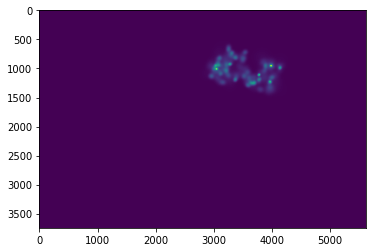

In [41]:
plt.imshow(dmaps[0])

In [44]:
import cv2

In [45]:
def show_density(im, density):
    max_density = np.max(density)
    normalized_density = density/max_density
    im_fp32 = im.astype(np.float32)
    im_masked = im_fp32.copy()
    im_masked[:,:,0] = (im_fp32[:,:,0] * normalized_density)
    im_masked[:,:,1] = (im_fp32[:,:,1] * normalized_density)
    im_masked[:,:,2] = (im_fp32[:,:,2] * normalized_density)
    return im_masked.astype(np.uint8), (normalized_density * 255).astype(np.uint8)

In [47]:
im_density, mask_density = show_density(im, dmaps[0])

In [48]:
cv2.imwrite("../data/im_density_cn.png", im_density)
cv2.imwrite("../data/mask_density_cn.png", mask_density)

True

In [42]:
sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point